# <font size="7">Define the Fourier-Net</font><a name="Definelayer">

## <font size="6">Define the CNN Architecture</font><a name="DefineCNN">

<font size="5">Input: a pair of stacked images.</font>

<font size="5">Output: the low-dimensional spatial representation of horizontal and vertical displacements (S_x and S_y).</font>

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# The CNN architecture used in Paper
# Define the CNN CNN(inputchannel, 2d or 3d displacments, startchannel)
#startchannel = 8, 16, 48 repsectively denote Fourier-Net small, Fourier-Net, and Fourier-Net large.
# The CNN is modified from ICNet and SYMNet
# https://github.com/zhangjun001/ICNet
# https://github.com/cwmok/Fast-Symmetric-Diffeomorphic-Image-Registration-with-Convolutional-Neural-Networks
class CNN(nn.Module):
    def __init__(self, in_channel, n_classes, start_channel):
        self.in_channel = in_channel
        self.n_classes = n_classes
        self.start_channel = start_channel

        bias_opt = True

        super(CNN, self).__init__()
        self.eninput = self.encoder(self.in_channel, self.start_channel, bias=bias_opt)
        self.ec1 = self.encoder(self.start_channel, self.start_channel, bias=bias_opt)
        self.ec2 = self.encoder(self.start_channel, self.start_channel * 2, stride=2, bias=bias_opt)
        self.ec3 = self.encoder(self.start_channel * 2, self.start_channel * 2, bias=bias_opt)
        self.ec4 = self.encoder(self.start_channel * 2, self.start_channel * 4, stride=2, bias=bias_opt)
        self.ec5 = self.encoder(self.start_channel * 4, self.start_channel * 4, bias=bias_opt)
        self.ec6 = self.encoder(self.start_channel * 4, self.start_channel * 8, stride=2, bias=bias_opt)
        self.ec7 = self.encoder(self.start_channel * 8, self.start_channel * 8, bias=bias_opt)
        self.ec8 = self.encoder(self.start_channel * 8, self.start_channel * 16, stride=2, bias=bias_opt)
        self.ec9 = self.encoder(self.start_channel * 16, self.start_channel * 8, bias=bias_opt)
        self.r_dc1 = self.encoder(self.start_channel * 8 + self.start_channel * 8, self.start_channel * 8, kernel_size=3,stride=1, bias=bias_opt)
        self.r_dc2 = self.encoder(self.start_channel * 8, self.start_channel * 4, kernel_size=3, stride=1, bias=bias_opt)
        self.r_dc3 = self.encoder(self.start_channel * 4 + self.start_channel * 4, self.start_channel * 4, kernel_size=3,stride=1, bias=bias_opt)
        self.r_dc4 = self.encoder(self.start_channel * 4, self.start_channel * 2, kernel_size=3, stride=1, bias=bias_opt)
        self.rr_dc9 = self.outputs(self.start_channel * 2, self.n_classes, kernel_size=3, stride=1, padding=1, bias=False)
        self.r_up1 = self.decoder(self.start_channel * 8, self.start_channel * 8)
        self.r_up2 = self.decoder(self.start_channel * 4, self.start_channel * 4)

    def encoder(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,bias=False, batchnorm=False):
        layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
            nn.PReLU())
        return layer

    def decoder(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0,output_padding=0, bias=True):
        layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride,padding=padding, output_padding=output_padding, bias=bias),
            nn.PReLU())
        return layer

    def outputs(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0,bias=False, batchnorm=False):
        layer = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias))
        return layer

    def forward(self, x, y):
        # Four downsmapling layers
        x_in = torch.cat((x, y), 1)
        e0 = self.eninput(x_in)
        e0 = self.ec1(e0)
        # 1st downsmapling layer
        e1 = self.ec2(e0)
        e1 = self.ec3(e1)
        # 2nd downsmapling layer
        e2 = self.ec4(e1)
        e2 = self.ec5(e2)
        # 3rd downsmapling layer
        e3 = self.ec6(e2)
        e3 = self.ec7(e3)
        # 4rd downsmapling layer
        e4 = self.ec8(e3)
        e4 = self.ec9(e4)
        # Two upsmapling layers
        # 1st upsmapling layer
        r_d0 = torch.cat((self.r_up1(e4), e3), 1)
        r_d0 = self.r_dc1(r_d0)
        r_d0 = self.r_dc2(r_d0)
        # 2nd upsmapling layer
        r_d1 = torch.cat((self.r_up2(r_d0), e2), 1)
        r_d1 = self.r_dc3(r_d1)
        r_d1 = self.r_dc4(r_d1)
        # Output layer
        # The 16 is ax6 in equation 4, which is optional
        # x16 or not does not affect the model convergence or final performance
        S_xy = self.rr_dc9(r_d1) * 16
        #f_x and f_y are the horizontal and vertical low-resolution displacements
        return S_xy[:,0:1,:,:], S_xy[:,1:2,:,:]

## <font size="6">Define the Warping Layer</font><a name="DefineWarping">

<font size="5">Input: moving image and a displacement.</font>

<font size="5">Ouput: the deformation grid and the warped moving image.</font>

In [2]:
class SpatialTransform(nn.Module):
    def __init__(self):
        super(SpatialTransform, self).__init__()
    def forward(self, mov_image, flow, mod = 'bilinear'):
        h2, w2 = mov_image.shape[-2:]
        grid_h, grid_w = torch.meshgrid([torch.linspace(-1, 1, h2), torch.linspace(-1, 1, w2)])
        grid_w = nn.Parameter(grid_w, requires_grad=False)
        grid_h = nn.Parameter(grid_h, requires_grad=False)
        flow_h = flow[:,:,:,0]
        flow_w = flow[:,:,:,1]
        disp_h = (grid_h + (flow_h)).squeeze(1)
        disp_w = (grid_w + (flow_w)).squeeze(1)
        sample_grid = torch.stack((disp_w, disp_h), 3)  # shape (N, H, W, 3)
        warped = torch.nn.functional.grid_sample(mov_image, sample_grid, mode = mod, align_corners = True)
        return sample_grid, warped

# <font size="7">Foward Propagation</font><a name="Forward">

## <font size="6">Load the Saved Model<a name="LoadModel"></font>

<font size="5">The best model is selected from the Validation set.</font>
    
<font size="5">Here, we use the Fourier-Net-Small.</font>

In [3]:
# The CNN in Encoder CNN(inputchannel, 2d or 3d displacments, startchannel)
#startchannel = 8, 16, 48 repsectively denote Fourier-Net small, Fourier-Net, and Fourier-Net large.
encoder_cnn = CNN(2,2,8) #Input are stacked image pair, therefore inputchannel=2
# model
with torch.no_grad():
    encoder_cnn.eval()
    encoder_cnn.load_state_dict(torch.load('DiceVal_0.74869_Epoch_000317580.pth'), strict = False)

## <font size="6">Load the Moving and Fixed Images<a name="LoadImage"></font>

<font size="5">Two random images are selected here.</font>

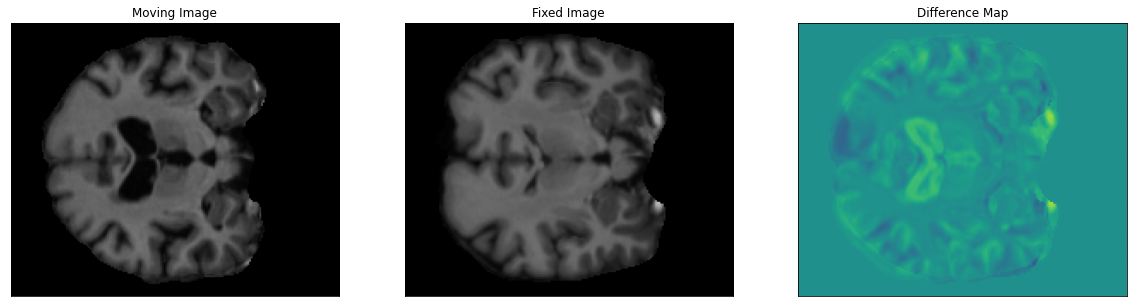

In [4]:
# Load moving and fixed images
# Plot them with differences
import nibabel as nib
mov_img_nib = nib.load('./OASIS_OAS1_0001_MR1/slice_norm.nii.gz')
mov_img = mov_img_nib.get_fdata()[:,:,0]
fix_img_nib = nib.load('./OASIS_OAS1_0002_MR1/slice_norm.nii.gz')
fix_img = fix_img_nib.get_fdata()[:,:,0]

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
plt.rc('axes', titlesize=40)
ax1.imshow(mov_img, cmap='gray', vmin=0, vmax=1)
ax1.title.set_text('Moving Image')
ax2.imshow(fix_img, cmap='gray', vmin=0, vmax=1)
ax2.title.set_text('Fixed Image')
ax3.imshow(fix_img-mov_img, vmin=-1, vmax=1)
ax3.title.set_text('Difference Map')
plt.rc('axes', titlesize=40)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
plt.show()


torch_mov_img = torch.from_numpy(mov_img).unsqueeze(0).unsqueeze(0).float()
torch_fix_img = torch.from_numpy(fix_img).unsqueeze(0).unsqueeze(0).float()


## <font size="6">Encode</font><a name="Encode">

<font size="5">Obtain the low-dimensional spatial displacement.</font>
    

<font size="5">Use DFT to convert it to the Fourier domain.</font>

In [5]:
# Input these two images into the CNN
low_spatial_repsentatoin_x, low_spatial_repsentatoin_y=encoder_cnn(torch_mov_img, torch_fix_img)
#DFT
bandlimited_x = torch.fft.fftshift(torch.fft.fft2(low_spatial_repsentatoin_x.squeeze(0).squeeze(0)))
bandlimited_y = torch.fft.fftshift(torch.fft.fft2(low_spatial_repsentatoin_y.squeeze(0).squeeze(0)))

## <font size="6">Decode</font><a name="Decode">
    

<font size="5">Zero pad the band-limited displacement to full resolution.</font>
    

<font size="5">Use iDFT to convert it to the spatial domain.</font>

In [6]:
#Padding to the orginal resolution
p3d = (72, 72, 60, 60)
zeropad_bandlimited_x = F.pad(bandlimited_x, p3d, "constant", 0)
zeropad_bandlimited_y = F.pad(bandlimited_y, p3d, "constant", 0)
#iDFT
disp_x = torch.real(torch.fft.ifft2(torch.fft.ifftshift(zeropad_bandlimited_x)))
disp_y = torch.real(torch.fft.ifft2(torch.fft.ifftshift(zeropad_bandlimited_y)))

final_spatial_disp = torch.cat([disp_x.unsqueeze(0).unsqueeze(0), disp_y.unsqueeze(0).unsqueeze(0)], dim = 1)

# <font size="7">Warping</font><a name="Warp">

In [7]:
transform = SpatialTransform()
grid, warp_mov_img = transform(torch_mov_img, final_spatial_disp.permute(0, 2, 3, 1), mod = 'bilinear')
warp_mov_img = warp_mov_img.detach().numpy().squeeze(0).squeeze(0)

## <font size="6">Plot the Band-limited Displacement</font><a name="PlotDisp">

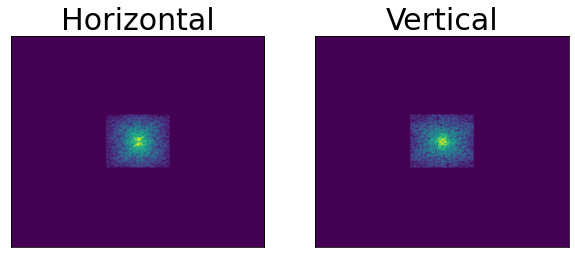

In [8]:
magnitude_x=np.log(1+abs(zeropad_bandlimited_x.detach().numpy()));
magnitude_y=np.log(1+abs(zeropad_bandlimited_y.detach().numpy()));
fig = plt.figure(figsize=(10, 5))
plt.rc('axes', titlesize=30)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(magnitude_x)
ax1.title.set_text('Horizontal')
ax2.imshow(magnitude_y)
ax2.title.set_text('Vertical')
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
plt.show()

## <font size="6">Plot the Deforamtion Grid</font><a name="PlotGrid">

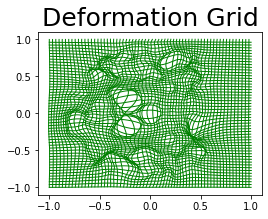

In [9]:
grid = grid.permute(0, 3, 1, 2).detach().numpy()
op_flow =grid[0,:,:,:]
interval = 3
plt.subplots(figsize=(4, 3))
plt.rc('axes', titlesize=25)
plt.title('Deformation Grid')
#plot the horizontal lines
for i in range(0,op_flow.shape[1]-1,interval):
    plt.plot(op_flow[0,i,:], op_flow[1,i,:],c='g',lw=1)
#plot the vertical lines
for i in range(0,op_flow.shape[2]-1,interval):
    plt.plot(op_flow[0,:,i], op_flow[1,:,i],c='g',lw=1)

## <font size="6">Plot the Warped Image</font><a name="PlotWarp">

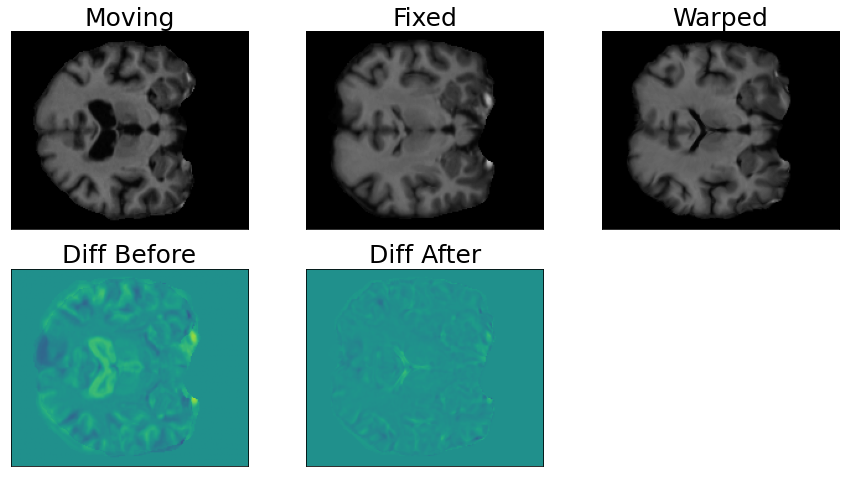

In [10]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax1.imshow(mov_img, cmap='gray', vmin=0, vmax=1.)
ax1.title.set_text('Moving')
ax2.imshow(fix_img, cmap='gray', vmin=0, vmax=1.)
ax2.title.set_text('Fixed')
ax3.imshow(warp_mov_img, cmap='gray', vmin=0, vmax=1.)
ax3.title.set_text('Warped')
ax4.imshow(fix_img-mov_img, vmin=-1, vmax=1.)
ax4.title.set_text('Diff Before')
ax5.imshow(fix_img-warp_mov_img, vmin=-1, vmax=1.)
ax5.title.set_text('Diff After')
plt.rc('axes', titlesize=30)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
plt.show()